In [2]:
import os
import shutil
import glob
import matplotlib.pyplot as plt
import pandas as pd

import torch

In [3]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f"Using device: cuda:{device}")
else:
    print("No GPU available")

Using device: cuda:0


In [41]:
img_paths = glob.glob("/work/LitArt/data/images/*")

In [5]:
img_data = pd.read_csv("/work/LitArt/data/images_segregated/resolution_100/Fantasy.csv")

In [7]:
img_data.head()

,ID,URI,Title,Author,Publication Date,Genres,Synopsis,URL,isImageAvailable,imageLocation
0,10862,/m/02y0x,The Metamorphosis,NaN,1915,"Children's literature, Absurdist fiction, Nove...","One day Gregor Samsa, a traveling salesman, w...",https://www.goodreads.com/book/show/485894.The...,True,/work/LitArt/data/images_segregated/resolution...
1,42572,/m/0bpn5,The Eye of the World,Robert Jordan,1990-01-15,"Speculative fiction, Fantasy, High fantasy",The Eye of the World revolves around the live...,https://www.goodreads.com/book/show/228665.The...,True,/work/LitArt/data/images_segregated/resolution...
2,42573,/m/0bpnk,The Great Hunt,Robert Jordan,1990-11-15,"Speculative fiction, Fantasy",Ba'alzamon presides over a clandestine meetin...,https://www.goodreads.com/book/show/233649.The...,True,/work/LitArt/data/images_segregated/resolution...
3,42575,/m/0bpp8,Winter's Heart,Robert Jordan,2000-11-07,"Speculative fiction, Fantasy",Many of the events of Winter's Heart take pla...,https://www.goodreads.com/book/show/13891.Wint...,True,/work/LitArt/data/images_segregated/resolution...
4,52853,/m/0dwms,Alice's Adventures in Wonderland,Lewis Carroll,1865-11-26,"Children's literature, Fantasy, Speculative fi...",Chapter 1 – Down the Rabbit Hole: Alice is fe...,https://www.goodreads.com/book/show/24213.Alic...,True,/work/LitArt/data/images_segregated/resolution...


In [7]:
img_data['synopsis_length'] = img_data.Synopsis.apply(lambda x:len(x.split()))

<Axes: ylabel='Frequency'>

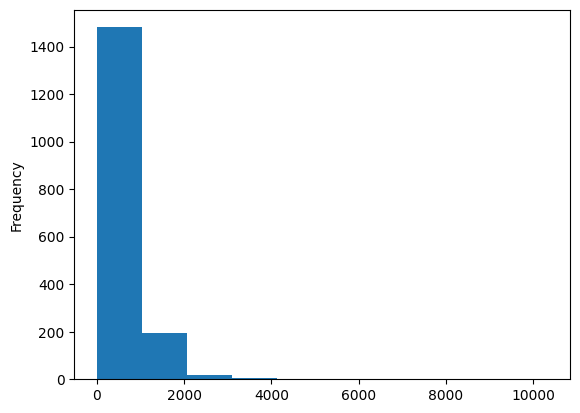

In [8]:
img_data.synopsis_length.plot(kind='hist')

## Data Creation

In [9]:
print(f"{len(img_data[(img_data.synopsis_length<100)&(img_data.synopsis_length>10)])/len(img_data)*100}% summaries have a length under 100 words and more than 10")

11.64021164021164% summaries have a length under 100 words and more than 10


In [10]:
## Trimming dataset to have summaries with length greater than 10 and less than 100

data_subset = img_data[(img_data.synopsis_length<100)&(img_data.synopsis_length>10)]

In [11]:
data_subset.head()

,ID,URI,Title,Author,Publication Date,Genres,Synopsis,URL,isImageAvailable,imageLocation,synopsis_length
92,269878,/m/01ns5b,Blood of Amber,Roger Zelazny,1986,"Speculative fiction, Fantasy","Merlin escapes from the crystal cave, and dec...",https://www.goodreads.com/book/show/239924.Blo...,True,/work/LitArt/data/images/Blood_of_Amber-Roger_...,63
94,269893,/m/01ns8r,Prince of Chaos,Roger Zelazny,1991-11,"Speculative fiction, Fantasy",Merlin returns to his birthplace in the Court...,https://www.goodreads.com/book/show/61994.Prin...,True,/work/LitArt/data/images/Prince_of_Chaos-Roger...,82
113,342518,/m/01y8vz,Gilgamesh the King,Robert Silverberg,1984,"Speculative fiction, Fantasy",The novel is told from the point of view of G...,https://www.goodreads.com/book/show/768871.Gil...,True,/work/LitArt/data/images/Gilgamesh_the_King-Ro...,84
116,352250,/m/01zf5s,The Plague Dogs,Richard Adams,1977-09-22,"Speculative fiction, Fantasy, Fiction","This book tells of the escape of two dogs, Ro...",https://www.goodreads.com/book/show/12442.The_...,True,/work/LitArt/data/images/The_Plague_Dogs-Richa...,97
138,421290,/m/026h6d,The Story of the Stone,Barry Hughart,1988,"Speculative fiction, Fantasy",The abbot of a humble monastery in the Valley...,https://www.goodreads.com/book/show/139874.The...,True,/work/LitArt/data/images/The_Story_of_the_Ston...,81


In [12]:
## copying subset images to train folder
destination_path = "../data/genre_fantasy/"

img_paths = data_subset.imageLocation.tolist()

os.makedirs(destination_path, exist_ok=True)

for img_path in img_paths[4:]:
    try:
        filename = os.path.basename(img_path)
        extension = os.path.splitext(filename)[1]

        new_filename = f"{filename[:-len(extension)]}{extension}"

        new_destination_path = os.path.join(destination_path, new_filename)

        shutil.copy2(img_path, new_destination_path)
    except Exception as e:
        print(f"Error transferring {img_path}: {e}")

In [13]:
metadata = pd.DataFrame({'file_name':data_subset.imageLocation.tolist(),'text':data_subset.Synopsis.tolist()})

In [14]:
metadata.dropna(subset=['file_name'],inplace=True)

In [15]:
metadata.file_name = metadata.file_name.apply(lambda x: os.path.basename(x))

In [16]:
metadata.head(2)

,file_name,text
0,Blood_of_Amber-Roger_Zelazny.jpg,"Merlin escapes from the crystal cave, and dec..."
1,Prince_of_Chaos-Roger_Zelazny.jpg,Merlin returns to his birthplace in the Court...


In [18]:
metadata.to_csv("../data/train/metadata.csv",index=False)

## Loading the new dataset

In [20]:
from datasets import  load_dataset

dataset = load_dataset("imagefolder", data_dir = "../data/",split='train')

Generating train split: 194 examples [00:00, 6028.84 examples/s]


In [21]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 194
})

In [65]:
export MODEL_NAME="CompVis/stable-diffusion-v1-4"
export INSTANCE_DIR="../data/"
export OUTPUT_DIR="./trained_models/"

In [66]:
%run accelerate launch train_dreambooth.py \
  --mixed_precision="fp16" \
  --pretrained_model_name_or_path=MODEL_NAME  \
  --instance_data_dir=INSTANCE_DIR \
  --output_dir=OUTPUT_DIR \
  --instance_prompt="a <book cover> for a magical fantasy book" \
  --train_text_encoder \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --learning_rate=2e-6 \
  --lr_scheduler="DDIM" \
  --lr_warmup_steps=0 \
  --max_train_steps=400 \
  --gradient_checkpointing \
  --use_8bit_adam \

ValueError: No escaped character